In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
cwd = os.getcwd()
cwd

'/Users/michelle/MIDS/210 Capstone'

# Read in files

In [4]:
# read in CSVs
nei2002 = pd.read_csv('cal_nei_2002_b.csv', low_memory=False)
nei2005 = pd.read_csv('cal_nei_2005_b.csv', low_memory=False)
nei2008 = pd.read_csv('cal_nei_2008_b.csv', low_memory=False)
nei2011 = pd.read_csv('cal_nei_2011_b.csv', low_memory=False)
nei2014 = pd.read_csv('cal_nei_2014_b.csv', low_memory=False)
nei2017 = pd.read_csv('cal_nei_2017_b.csv', low_memory=False)

# display all columns in pandas
pd.set_option('display.max_columns', None)

df_list = [nei2002, nei2005, nei2008, nei2011, nei2014, nei2017]

# name DFs
nei2002.name = 'nei2002'
nei2005.name = 'nei2005'
nei2008.name = 'nei2008'
nei2011.name = 'nei2011'
nei2014.name = 'nei2014'
nei2017.name = 'nei2017'

In [56]:
def subset_data(dataset, zip_code_col, lat_col, lon_col, threshold):
    
    
    subset_dict_emission_type_strs = {'nei2002': 'Pollutant_Code_Desc',
                             'nei2005': 'POLLUTANT_CODE',
                             'nei2008': 'description',
                             'nei2011': 'description',
                             'nei2014': 'pollutant_desc',
                             'nei2017': 'pollutant_desc', 
                            }
    
    subset_dict_pm25_strs = {'nei2002': 'Primary PM2.5 (Includes Filterables + Condensibles)',
                             'nei2005': ('PM25-FIL', 'PM25-PRI', 'PM-CON'),
                             'nei2008': 'PM2.5 Primary (Filt + Cond)',
                             'nei2011': 'PM2.5 Primary (Filt + Cond)',
                             'nei2014': 'PM2.5 Primary (Filt + Cond)',
                             'nei2017': 'PM2.5 Primary (Filt + Cond)'
                            }
    subset_dict_emissions_strs = {'nei2002': 'Emissions_TPY',
                             'nei2005': 'ANNUAL_EMISSIONS',
                             'nei2008': 'total_emissions_tons',
                             'nei2011': 'total_emissions_tons',
                             'nei2014': 'total_emissions_tons',
                             'nei2017': 'total_emissions_tons'
                            }
    subset_dict_site_ID_strs = {'nei2002': 'NEISiteID',
                             'nei2005': 'NTI_SITE_ID',
                             'nei2008': 'eis_facility_site_id',
                             'nei2011': 'eis_facility_site_id',
                             'nei2014': 'eis_facility_site_id',
                             'nei2017': 'eis_facility_id'
                            }
    dataset = dataset
    zip_code_col = zip_code_col
    lat_col = lat_col
    lon_col = lon_col
    emission_type_col = subset_dict_emission_type_strs[dataset.name]
    pm25_str = subset_dict_pm25_strs[dataset.name]
    emissions_tons_col = subset_dict_emissions_strs[dataset.name]
    ID_col = subset_dict_site_ID_strs[dataset.name]
    report_year_col = 'report_year'
    
    threshold = threshold
    if threshold >= 1:
        threshold = (100-threshold)/100
        pct_threshold = threshold
    elif threshold < 1:
        threshold = 1-threshold
        pct_threshold = (1-threshold)*100
        
    try:
        selected_cols = dataset[[emission_type_col, emissions_tons_col, zip_code_col, lat_col, lon_col, report_year_col]] #didn't use ID_col
    except KeyError:
        dataset['report_year'] = dataset.name[-4:]
        selected_cols = dataset[[emission_type_col, emissions_tons_col, zip_code_col, lat_col, lon_col, report_year_col]]
        
    selected_cols.sort_values(emissions_tons_col, ascending=True)
    if dataset.name == 'nei2005':
        filtered_pm25 = selected_cols[(selected_cols[emission_type_col] == pm25_str[0]) |
                                      (selected_cols[emission_type_col] == pm25_str[1]) |
                                      (selected_cols[emission_type_col] == pm25_str[2])]
    else:
        filtered_pm25 = selected_cols[selected_cols[emission_type_col] == pm25_str]
    sorted_emissions = filtered_pm25.groupby([lat_col, lon_col, zip_code_col, report_year_col]).sum().sort_values(by=emissions_tons_col, ascending=True)
    print("All PM 2.5 Emissions: \n {}\n\n".format(sorted_emissions.shape[0]))
    
    # if there's a threshold
    threshold_cutoff = sum(sorted_emissions[emissions_tons_col])*threshold
    threshold_idx = sorted_emissions[emissions_tons_col].cumsum().searchsorted(threshold_cutoff)
    sorted_emissions_threshold = sorted_emissions.iloc[threshold_idx:]
    quantiles = sorted_emissions_threshold[emissions_tons_col].quantile([.1, .25, .5, .75, .85, .9, .95, .97, .99])
    print("Top {}% of PM 2.5 Emissions: \n {}\n\n".format((1-threshold)*100, sorted_emissions_threshold.shape[0]))
    sorted_emissions_threshold.hist(column=emissions_tons_col, bins=20, log=True)
    print("\nQuantiles:\n{}".format(quantiles))
    
    # write csv
    str_pct_threshold = str(pct_threshold)
    csv_name = dataset.name + '_' + str_pct_threshold + '_subset.csv'
    sorted_emissions_threshold.to_csv(csv_name)
    
    return sorted_emissions_threshold



All PM 2.5 Emissions: 
 4957


Top 95.0% of PM 2.5 Emissions: 
 918



Quantiles:
0.10      2.216302
0.25      3.046974
0.50      5.602466
0.75     14.011366
0.85     27.988884
0.90     43.315886
0.95     80.802680
0.97    104.605666
0.99    237.275238
Name: Emissions_TPY, dtype: float64


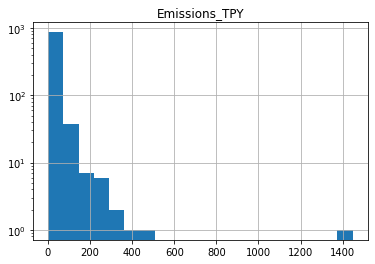

In [59]:
nei2002_subset = subset_data(nei2002, 'zip_code', 'checked_lat', 'checked_lon', 95)

All PM 2.5 Emissions: 
 8989


Top 95.0% of PM 2.5 Emissions: 
 1116



Quantiles:
0.10      2.100552
0.25      2.818948
0.50      5.007947
0.75     12.364831
0.85     22.687622
0.90     37.619061
0.95     81.291796
0.97    131.466252
0.99    275.660043
Name: ANNUAL_EMISSIONS, dtype: float64


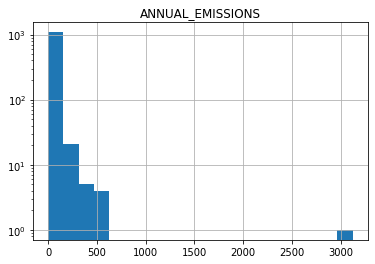

In [60]:
nei2005_subset = subset_data(nei2005, 'zip_code', 'checked_lat', 'checked_lon', 95)

All PM 2.5 Emissions: 
 10822


Top 95.0% of PM 2.5 Emissions: 
 1137



Quantiles:
0.10      1.803963
0.25      2.378963
0.50      4.075550
0.75      9.822665
0.85     18.387921
0.90     30.508300
0.95     66.966288
0.97    116.906963
0.99    278.983337
Name: total_emissions_tons, dtype: float64


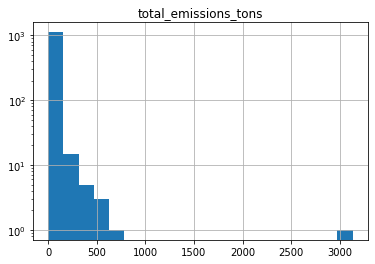

In [61]:
nei2008_subset = subset_data(nei2008, 'zip_code', 'checked_lat', 'checked_lon', 95)

All PM 2.5 Emissions: 
 11940


Top 95.0% of PM 2.5 Emissions: 
 1323



Quantiles:
0.10      1.389241
0.25      1.823415
0.50      3.140000
0.75      7.566396
0.85     13.975161
0.90     22.382305
0.95     46.732699
0.97     73.654351
0.99    207.415104
Name: total_emissions_tons, dtype: float64


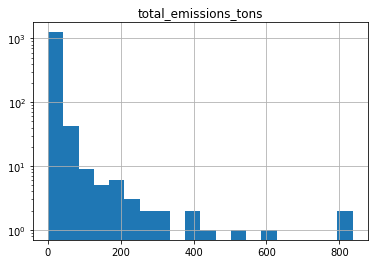

In [62]:
nei2011_subset = subset_data(nei2011, 'zip_code', 'checked_lat', 'checked_lon', 95)

All PM 2.5 Emissions: 
 13238


Top 95.0% of PM 2.5 Emissions: 
 1189



Quantiles:
0.10      1.400631
0.25      1.887280
0.50      3.262810
0.75      7.609207
0.85     13.823728
0.90     21.723010
0.95     39.599268
0.97     83.909140
0.99    246.200177
Name: total_emissions_tons, dtype: float64


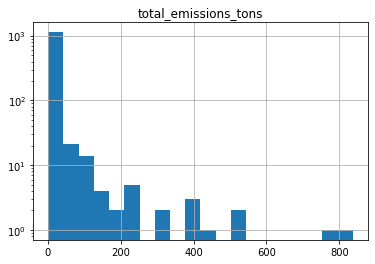

In [63]:
nei2014_subset = subset_data(nei2014, 'zip_code', 'checked_lat', 'checked_lon', 95)



All PM 2.5 Emissions: 
 14657


Top 95.0% of PM 2.5 Emissions: 
 1466



Quantiles:
0.10      0.986259
0.25      1.340208
0.50      2.366512
0.75      5.522902
0.85      9.821495
0.90     14.310957
0.95     29.868929
0.97     54.333953
0.99    127.587689
Name: total_emissions_tons, dtype: float64


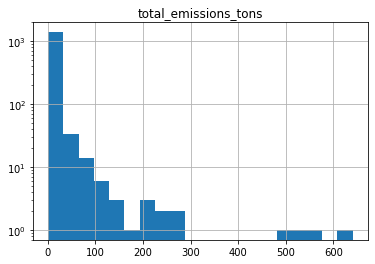

In [64]:
nei2017_subset = subset_data(nei2017, 'zip_code', 'checked_lat', 'checked_lon', 95)

In [65]:
# Standardize titles

df_subset_list = [nei2002_subset, nei2005_subset, nei2008_subset, nei2011_subset, nei2014_subset, nei2017_subset]

for i in df_subset_list:
    i.rename(columns={'Emissions_TPY': 'PM25_emissions_TPY',
                   'ANNUAL_EMISSIONS': 'PM25_emissions_TPY',
                   'total_emissions_tons': 'PM25_emissions_TPY'
                  }, inplace=True
            )

In [66]:
nei2002_subset

,,,,PM25_emissions_TPY
checked_lat,checked_lon,zip_code,report_year,
33.811466,-117.915550,92803.0,2002,1.787854
34.088242,-117.470116,92335.0,2002,1.789200
33.911602,-118.281799,93420.0,2002,1.791300
37.944618,-121.325859,95203.0,2002,1.797500
39.221817,-121.054955,95945.0,2002,1.801540
...,...,...,...,...
38.025414,-122.113251,94553.0,2002,307.379504
34.603149,-117.338593,92368.0,2002,312.212247
38.370838,-120.808243,95654.0,2002,413.799008


In [72]:
nei2005

,Unnamed: 0.1,Unnamed: 0,TRIBAL_CODE,STATE_ABBREV,STATE_AND_COUNTY_FIPS_CODE,FACILITY_REGISTRY_IDENTIFIER,STATE_FACILITY_IDENTIFIER,NTI_SITE_ID,ORIS_FACILITY_CODE,FACILITY_NAME,LOCATION_ADDRESS,CITY,STATE,ZIPCODE,SIC_PRIMARY,NAICS_PRIMARY,NAICS_FLAG,EMISSION_UNIT_ID,ORIS_BOILER_ID,PROCESS_ID,SCC,EMISSION_RELEASE_POINT_ID,EMISSION_RELEASE_POINT_TYPE,STACK_HEIGHT,EXIT_GAS_TEMPERATURE,STACK_DIAMETER,EXIT_GAS_VELOCITY,EXIT_GAS_FLOW_RATE,STACK_DEFAULT_FLAG,X_COORDINATE,Y_COORDINATE,LOCATION_DEFAULT_FLAG,POLLUTANT_CODE,ANNUAL_EMISSIONS,PROCESS_MACT_CODE,PROCESS_MACT_COMPLIANCE_STATUS,MACT_FLAG,FACILITY_CATEGORY,HAP_EMISSIONS_PERFORMANCE_LEVL,START_DATE,END_DATE,PERIOD_DAYS_PER_WEEK,EMISSION_TYPE,CONTROL_STATUS,DESCRIPTION,checked_lat,checked_lon,cap_hap,POLLUTANT_CODE_DESCRIPTION,HAP_CATEGORY_NAME,zip_code,report_year
0,0,0,0,CA,6013,1.100139e+11,07130310871,NEIRCA310871,NaN,SYAR INDUSTRIES INC,5 PARR BOULEVARD,RICHMOND,CA,94801,2951,324121,NaN,7,NaN,1,30500611,4,2,25.00,74,0.400,1.4200,0.17844,11111,-122.376213,37.969330,SITEAVG,PM-FIL,0.069560,NaN,NaN,NaN,1.0,NaN,20050101,20051231,5.0,30,UNCONTROLLED,NaN,-122.376213,-122.376213,CAP,NaN,NaN,94801.0,2005
1,1,1,0,CA,6013,1.100211e+11,07130313076,NEI2CA313076,NaN,"CENTRAL CONCRETE SUPPLY, INC",2770 N MAIN STREET,WALNUT CREEK,CA,94596,2951,324121,NaN,18,NaN,1,30500618,1,2,93.49,110,1.947,40.3719,120.20320,11111,-122.063068,37.925010,Exact,PM-FIL,0.027260,NaN,NaN,NaN,1.0,NaN,20050101,20051231,7.0,30,CONTROLLED,NaN,-122.063068,-122.063068,CAP,NaN,NaN,94596.0,2005
2,2,2,0,CA,6013,1.100200e+11,07130314628,NEI2CA314628,NaN,TESORO REFINING AND MARKETING,Avon Refinery,MARTINEZ,CA,94553,2911,32411,NaN,954,NaN,1,20200202,53,2,27.08,745,1.448,57.3041,94.32229,11111,-122.064821,37.990313,Exact,NOX,0.826000,0105-1,1.0,SCC-Default,1.0,NaN,20050101,20051231,7.0,30,CONTROLLED,NaN,-122.064821,-122.064821,CAP,NaN,NaN,94553.0,2005
3,3,3,0,CA,6013,NaN,07130316097,NEICA01307130316097,NaN,SUNGARD RECOVERY SERVICESLP,2481 DEERWOOD DRIVE,SAN RAMON,CA,94583-0000,7379,562920,NaN,1,NaN,1,20100102,69,2,38.51,617,2.923,72.9331,489.36240,11111,-121.992970,37.774340,Exact,NOX,0.088000,0105-2,3.0,SCC-Default,2.0,NaN,20050101,20051231,7.0,30,UNCONTROLLED,NaN,-121.992970,-121.992970,CAP,NaN,NaN,94583.0,2005
4,4,4,0,CA,6013,NaN,07130314077,NEICA01307130314077,NaN,S F BAY AREA RAPID TRANSIT DIS,1700 W LELAND AVENUE,PITTSBURG,CA,94565-0000,9621,92612,NaN,1,NaN,1,20100102,1,2,38.51,617,2.923,72.9331,489.36240,11111,-121.945683,38.015599,Exact,NOX,0.207000,0105-2,3.0,SCC-Default,2.0,NaN,20050101,20051231,7.0,30,UNCONTROLLED,NaN,-121.945683,-121.945683,CAP,NaN,NaN,94565.0,2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694423,694423,405677,0,CA,6059,1.100012e+11,30102679944H,NEI22005,NaN,BREITBURN ENERGY CORP,2001 PACIFIC COAST HWY,SEAL BEACH,CA,90740,1311,211111,NaN,70051,NaN,1,40400302,900015,1,10.00,72,0.003,0.0003,0.00000,3333,-118.081062,33.729931,NaN,108883,0.000915,0501,2.0,SCC-DEFAULT,1.0,1.0,20020101,20021231,0.0,30,CONTROLLED,Regional Planning Organization data,-118.081062,-118.081062,HAP,Toluene,Toluene,90740.0,2005
694424,694424,405678,0,CA,6077,NaN,39143030,NEICA07739143030,NaN,E&A CABRERA DBA PACIFIC MINI MART & GAS,4511 PACIFIC AVE,STOCKTON,CA,95207-0000,5541,44711,NaN,1,NaN,3,40600602,1,2,16.22,70,1.001,11.6367,9.15465,11111,-121.312113,37.989195,Exact,108883,0.011372,NaN,NaN,NaN,2.0,1.0,20050101,20051231,7.0,30,UNCONTROLLED,NaN,-121.312113,-121.312113,HAP,Toluene,Toluene,95207.0,2005
694425,694425,405679,0,CA,6077,1.100140e+11,391430104,NEICA0773911,NaN,USA PETROLEUM #3513,401 WEST KETTLEMAN LANE,LODI,CA,95240,5541,447190,NaN,1,NaN,1,40600306,1,2,33.00,69,0.330,0.3500,0.02994,11111,-121.173210,38.111217,ALLNEI07,108883,0.027712,0601,3.0,SCC-Default,2.0,1.0,20050101,20051231,7.0,30,UNCONTROLLED,NaN,-121.173210,-121.173210,HAP,Toluene,Toluene,

In [68]:
nei2008_subset

,,,,PM25_emissions_TPY
checked_lat,checked_lon,zip_code,report_year,
32.797000,-115.646000,92243,2008,1.527860
33.774140,-116.968520,92583,2008,1.534657
34.189600,-119.166020,93030,2008,1.537600
34.227270,-118.382290,91352,2008,1.540700
36.677660,-119.752690,93725,2008,1.540854
...,...,...,...,...
34.566396,-117.994191,93552,2008,488.354638
34.604500,-117.338200,92368,2008,582.730058
34.354500,-116.853200,92356,2008,622.355861


In [69]:
nei2011_subset

,,,,PM25_emissions_TPY
checked_lat,checked_lon,zip_code,report_year,
33.619160,-114.716880,0,2011,1.161023
33.867235,-118.257363,90747,2011,1.161820
38.468370,-122.722690,95403,2011,1.161931
32.781540,-116.888540,92019,2011,1.163224
38.694320,-121.747760,95776,2011,1.163970
...,...,...,...,...
34.354500,-116.853200,92356,2011,421.459265
34.567400,-117.993100,93552,2011,507.813288
37.938779,-122.396453,94802,2011,590.108463


In [70]:
nei2014_subset

,,,,PM25_emissions_TPY
checked_lat,checked_lon,zip_code,report_year,
38.376800,-120.793910,0,2014,1.177475
34.113981,-117.984697,91706,2014,1.180108
38.017730,-121.856220,94565,2014,1.181507
35.419205,-118.926540,93308,2014,1.181557
37.642100,-122.135900,94545,2014,1.181899
...,...,...,...,...
37.938779,-122.396453,94802,2014,430.160158
34.567400,-117.993100,93552,2014,507.831621
38.016594,-122.115392,94553,2014,537.715214


In [71]:
nei2017_subset

,,,,PM25_emissions_TPY
checked_lat,checked_lon,zip_code,report_year,
33.359400,-117.111400,92059.0,2017,0.784458
37.493617,-121.935869,0.0,2017,0.784750
32.821000,-117.144000,92123.0,2017,0.785131
38.734600,-121.954430,95695.0,2017,0.786000
35.352150,-119.240640,93312.0,2017,0.790105
...,...,...,...,...
38.025100,-122.063900,94553.0,2017,265.824083
34.622200,-117.100100,92307.0,2017,494.738668
34.231230,-116.056220,92778.0,2017,534.734811


In [76]:
concat_dataset = pd.concat([nei2002_subset, nei2005_subset, nei2008_subset, nei2011_subset, nei2014_subset, nei2017_subset], axis=0)
concat_dataset

,,,,PM25_emissions_TPY
checked_lat,checked_lon,zip_code,report_year,
33.811466,-117.915550,92803.0,2002,1.787854
34.088242,-117.470116,92335.0,2002,1.789200
33.911602,-118.281799,93420.0,2002,1.791300
37.944618,-121.325859,95203.0,2002,1.797500
39.221817,-121.054955,95945.0,2002,1.801540
...,...,...,...,...
38.025100,-122.063900,94553.0,2017,265.824083
34.622200,-117.100100,92307.0,2017,494.738668
34.231230,-116.056220,92778.0,2017,534.734811


In [77]:
concat_dataset.to_csv('pollution_point_sources.csv')